In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
import matplotlib.pyplot as plt
import PDEparams as pde

In [2]:
data = pd.read_csv('covidcanada.csv')
data

,Day,date,numconf,numdeaths,numtotal,numrecover
0,1,31/01/2020,4,0,4,0
1,2,08/02/2020,7,0,7,0
2,3,16/02/2020,8,0,8,0
3,4,21/02/2020,9,0,9,0
4,5,24/02/2020,10,0,10,0
...,...,...,...,...,...,...
283,284,04/12/2020,402569,12496,402569,320096
284,285,05/12/2020,409568,12607,409568,324882
285,286,06/12/2020,416555,12693,416555,329138
286,287,07/12/2020,423054,12777,423054,338735


In [3]:
for j in range(287):
    data.loc[287-j, 'numconf']= data.loc[287-j, 'numconf'] - data.loc[287-j-1, 'numconf']


In [4]:
for j in range(287):
    data.loc[287-j, 'numdeaths']= data.loc[287-j, 'numdeaths'] - data.loc[287-j-1, 'numdeaths']


In [5]:
for j in range(287):
    data.loc[287-j, 'numrecover']= data.loc[287-j, 'numrecover'] - data.loc[287-j-1, 'numrecover']


In [6]:
data

,Day,date,numconf,numdeaths,numtotal,numrecover
0,1,31/01/2020,4,0,4,0
1,2,08/02/2020,3,0,7,0
2,3,16/02/2020,1,0,8,0
3,4,21/02/2020,1,0,9,0
4,5,24/02/2020,1,0,10,0
...,...,...,...,...,...,...
283,284,04/12/2020,6300,89,402569,5488
284,285,05/12/2020,6999,111,409568,4786
285,286,06/12/2020,6987,86,416555,4256
286,287,07/12/2020,6499,84,423054,9597


In [7]:
init_S= 37590000
init_I = 4
init_R = 0
N = init_S
d = {'days': data['Day'], 'infected': data['numconf']}
df = pd.DataFrame(data=d)


In [8]:
df

,days,infected
0,1,4
1,2,3
2,3,1
3,4,1
4,5,1
...,...,...
283,284,6300
284,285,6999
285,286,6987
286,287,6499


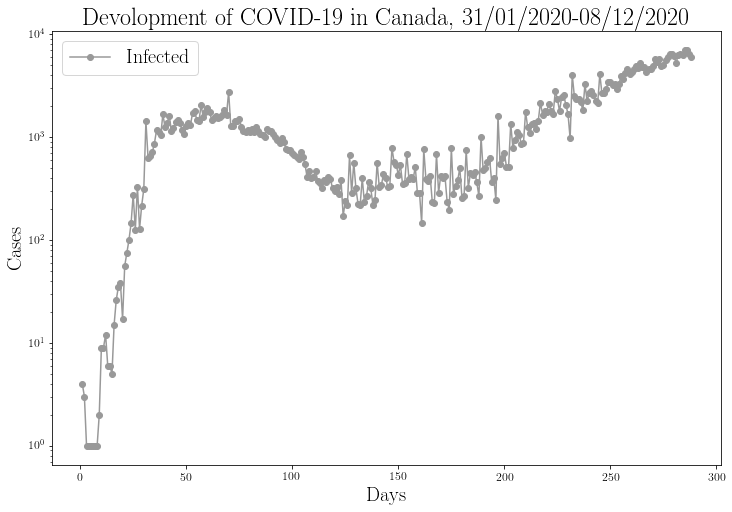

In [9]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 in Canada, 31/01/2020-08/12/2020")
plt.plot(df['days'], df['infected'], '-o', label="Infected")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days")
plt.legend()

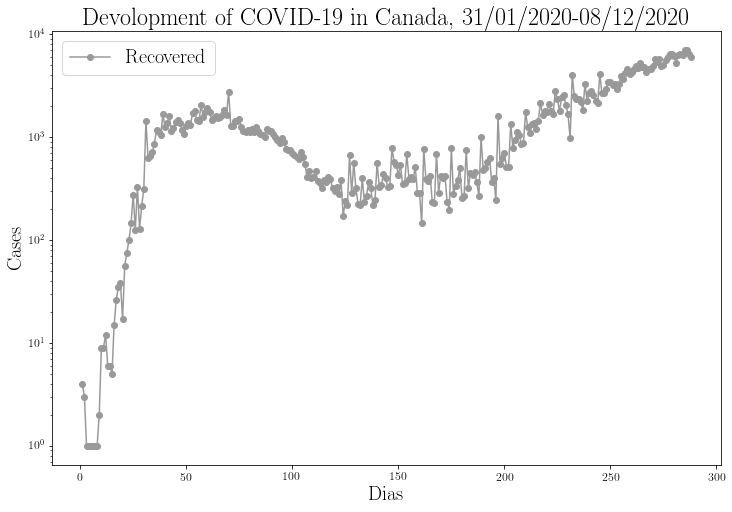

In [10]:
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 in Canada, 31/01/2020-08/12/2020")
plt.plot(df['days'], df['infected'], '-o', label="Recovered")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Dias")
plt.legend()

Definimos el modelo SIR

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$

$$\begin{align}
\beta &= \text{Ratio de contacto } \times \text{ Probabilidad de transmision}\\
\sigma &= \text{Ratio de incubación}\\
\gamma &= \text{Ratio de recuperación}
\end{align}$$

In [11]:
def SIRmodel(z, t, b, g):
    '''The input z corresponds to the current state of the system, z = [s, i, r]. Since the input is in 1D, no 
    pre-processing is needed.
    
    t is the current time.
    
    s = suceptibles
    i = infected
    r = recovered
    b = beta,
    o = sigma--- No se usa.
    g = gamma
    '''
    
    s, i, r = z
    
    return [-b*((s*i)/N), b*((s*i)/N)-g*i, g*i]

In [12]:
def initial_s():
    return init_S

def initial_i():
    return init_I

def initial_r():
    return init_R

In [13]:
my_model = pde.PDEmodel(df, SIRmodel, [initial_s, initial_i, initial_r], bounds=[(0, 5), (0,3)], 
                        param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [14]:
# Printing the initial condition
my_model.initial_condition

array([37590000,        4,        0])

In [15]:
%%time
my_model.fit()

        $b$       $g$
0  1.282549  1.254677
Wall time: 2.39 s


In [16]:
my_model.best_params

,$b$,$g$
0,1.282549,1.254677


In [17]:
my_model.best_error

518700.3766094965

In [18]:
my_model.likelihood_profiles()

In [19]:
my_model.result_profiles

,parameter,value,error
0,$b$,0.000000,4.900900e+06
1,$b$,0.050505,5.762121e+05
2,$b$,0.101010,5.757620e+05
3,$b$,0.151515,5.750152e+05
4,$b$,0.202020,5.739724e+05
...,...,...,...
195,$g$,2.878788,2.115302e+06
196,$g$,2.909091,2.160637e+06
197,$g$,2.939394,2.205437e+06
198,$g$,2.969697,2.249681e+06


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


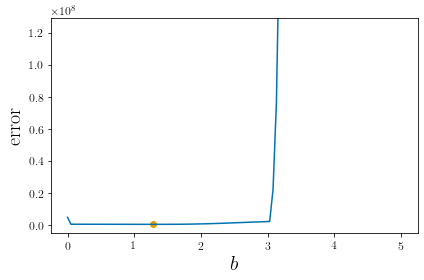

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


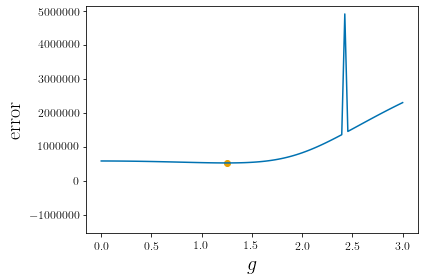

In [20]:
my_model.plot_profiles()

In [21]:
d2 = {'days': data['Day'], 'infected': data['numconf'], 'recovered': data['numrecover']+data['numdeaths']}
df2 = pd.DataFrame(data=d2)


In [22]:
my_model2 = pde.PDEmodel(df2, SIRmodel, [initial_s, initial_i, initial_r], bounds=[(0, 20), (0, 5)], 
                        param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1,2], outfunc=None)

In [23]:
%%time
my_model2.fit()

        $b$       $g$
0  0.047803  0.021454
Wall time: 2.7 s


In [24]:
my_model2.best_params

,$b$,$g$
0,0.047803,0.021454


In [25]:
my_model2.best_error

1476756.7045253655

In [ ]:
my_model2.likelihood_profiles()

In [ ]:
my_model2.result_profiles

In [ ]:
my_model2.plot_profiles()